## Подключение библиотек и скриптов

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# For running inference on the TF-Hub module.
import tensorflow as tf

import tensorflow_hub as hub

# For downloading the image.
import matplotlib.pyplot as plt
import tempfile
from six.moves.urllib.request import urlopen
from six import BytesIO

# For drawing onto the image.
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

# For measuring the inference time.
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
plt.rcParams.update({'font.size': 14})
pd.set_option('precision', 3)
pd.set_option('max_columns', 100)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('max_colwidth', 300)

## Tensorflow with GPU

In [5]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [6]:
def display_image(image):
  fig = plt.figure(figsize=(20, 15))
  plt.grid(False)
  plt.imshow(image)


def download_and_resize_image(url, new_width=256, new_height=256,
                              display=False):
  _, filename = tempfile.mkstemp(suffix='.jpg')
  response = urlopen(url)
  image_data = response.read()
  image_data = BytesIO(image_data)
  pil_image = Image.open(image_data)
  pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)
  pil_image_rgb = pil_image.convert('RGB')
  pil_image_rgb.save(filename, format='JPEG', quality=90)
  print('Image downloaded to %s.' % filename)
  if display:
    display_image(pil_image)
  return filename


def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness=2,
                               display_str_list=()):
  '''Adds a bounding box to an image.'''
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
  draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color)

  # If the total height of the display strings added to the top of the bounding
  # box exceeds the top of the image, stack the strings below the bounding box
  # instead of above.
  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
  # Each display_str has a top and bottom margin of 0.05x.
  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = top + total_display_str_height
  # Reverse list and print from bottom to top.
  for display_str in display_str_list[::-1]:
    text_width, text_height = font.getsize(display_str)
    margin = np.ceil(0.05 * text_height)
    draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                    (left + text_width, text_bottom)],
                   fill=color)
    draw.text((left + margin, text_bottom - text_height - margin),
              display_str,
              fill='black',
              font=font)
    text_bottom -= text_height - 2 * margin


def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.45):
  '''Overlay labeled boxes on an image with formatted scores and label names.'''
  colors = list(ImageColor.colormap.values())

  try:
    font = ImageFont.truetype('/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf',
                              20)
  except IOError:
    print('Font not found, using default font.')
    font = ImageFont.load_default()

  for i in range(min(boxes.shape[0], max_boxes)):
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i])
      display_str = '{}: {}%'.format(class_names[i].decode('ascii'),
                                     int(100 * scores[i]))
      color = colors[hash(class_names[i]) % len(colors)]
      image_pil = Image.fromarray(np.uint8(image)).convert('RGB')
      draw_bounding_box_on_image(
          image_pil,
          ymin,
          xmin,
          ymax,
          xmax,
          color,
          font,
          display_str_list=[display_str])
      np.copyto(image, np.array(image_pil))
  return image

Image downloaded to C:\Users\Djo\AppData\Local\Temp\tmpur3py4ke.jpg.


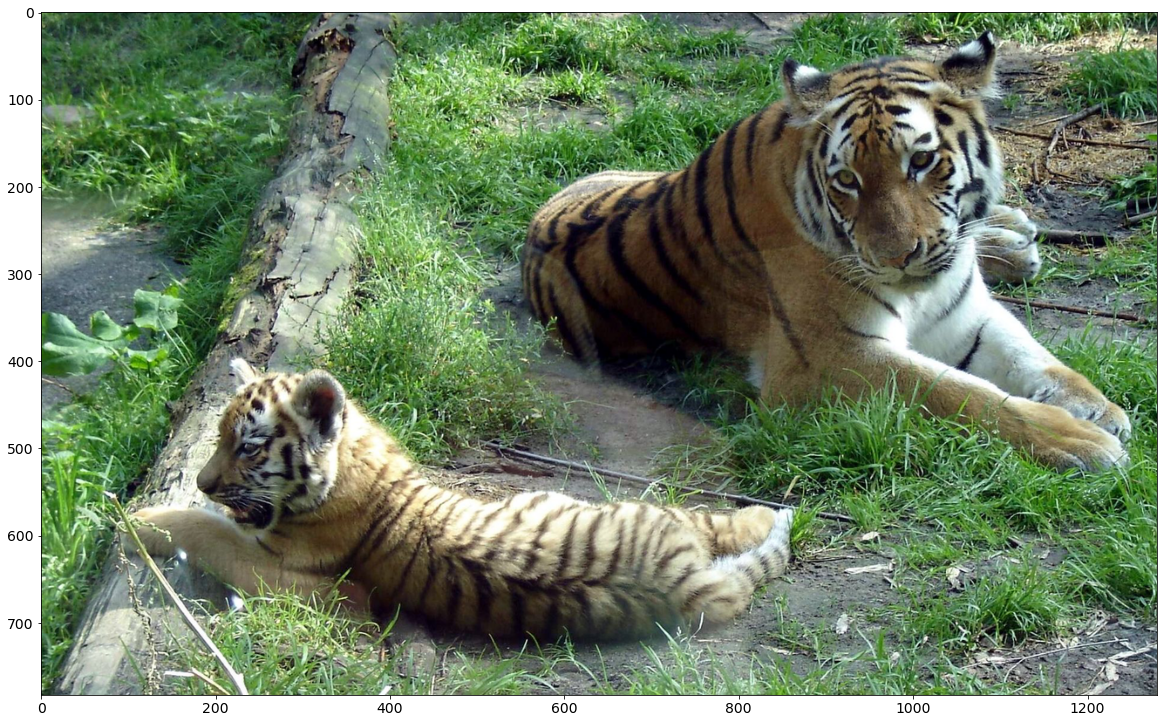

In [9]:
image_url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/4/49/Amersfoort_Zoo_Siberian_Tigers.jpg/1920px-Amersfoort_Zoo_Siberian_Tigers.jpg' 
downloaded_image_path = download_and_resize_image(image_url, 1280, 783, True)

In [11]:
module_handle = 'https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1'
detector = hub.load(module_handle).signatures['default']

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [12]:
def load_img(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  return img

In [13]:
def run_detector(detector, path):
  img = load_img(path)

  converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
  start_time = time.time()
  result = detector(converted_img)
  end_time = time.time()

  result = {key:value.numpy() for key,value in result.items()}

  print('Found %d objects.' % len(result['detection_scores']))
  print('Inference time: ', end_time-start_time)

  image_with_boxes = draw_boxes(
      img.numpy(), result['detection_boxes'],
      result['detection_class_entities'], result['detection_scores'])

  display_image(image_with_boxes)

Found 100 objects.
Inference time:  32.35671424865723
Font not found, using default font.


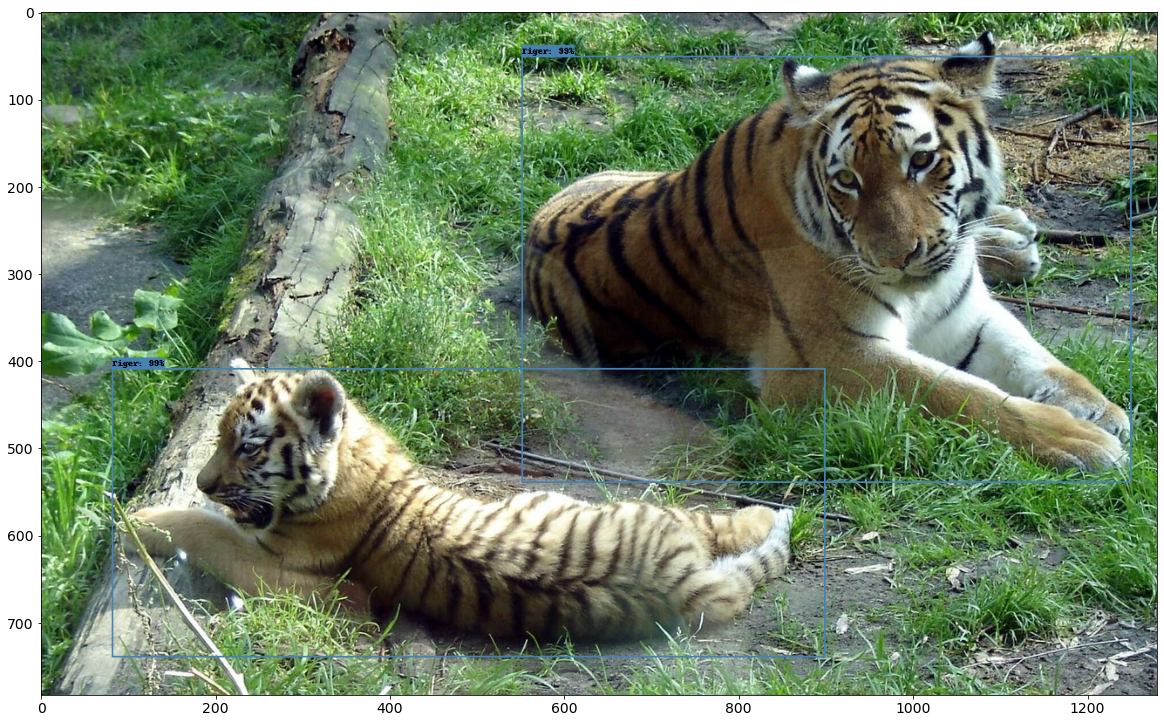

In [15]:
run_detector(detector, downloaded_image_path)

In [17]:
image_urls = [
'https://upload.wikimedia.org/wikipedia/commons/thumb/0/01/Moscow_July_2011-16.jpg/1920px-Moscow_July_2011-16.jpg'    
,'https://upload.wikimedia.org/wikipedia/commons/7/76/%D0%9C%D1%8D%D1%80%D0%B8%D1%8F.%D0%92%D0%BE%D1%80%D0%BE%D0%BD%D0%B5%D0%B6.jpg'
,'https://upload.wikimedia.org/wikipedia/commons/thumb/d/d5/%D0%92%D0%B0%D0%BB%D1%83%D0%B9%D0%BA%D0%B8._%D0%92%D0%B8%D0%B4_%D0%BD%D0%B0_%D0%9F%D0%BE%D0%B4%D0%BD%D0%B8%D0%B7%D0%BE%D0%B2%D0%BA%D1%83_%D0%B8_%D0%9A%D0%B0%D0%B7%D0%B0%D1%86%D0%BA%D1%83%D1%8E.jpeg/1920px-%D0%92%D0%B0%D0%BB%D1%83%D0%B9%D0%BA%D0%B8._%D0%92%D0%B8%D0%B4_%D0%BD%D0%B0_%D0%9F%D0%BE%D0%B4%D0%BD%D0%B8%D0%B7%D0%BE%D0%B2%D0%BA%D1%83_%D0%B8_%D0%9A%D0%B0%D0%B7%D0%B0%D1%86%D0%BA%D1%83%D1%8E.jpeg'
,'https://upload.wikimedia.org/wikipedia/commons/3/36/Chapel1.jpg'
]

In [18]:
def detect_img(image_url):
  start_time = time.time()
  image_path = download_and_resize_image(image_url, 640, 480)
  run_detector(detector, image_path)
  end_time = time.time()
  print('Inference time:', end_time-start_time)

Image downloaded to C:\Users\Djo\AppData\Local\Temp\tmpmd909j92.jpg.
Found 100 objects.
Inference time:  2.68520450592041
Font not found, using default font.
Inference time: 3.12552547454834


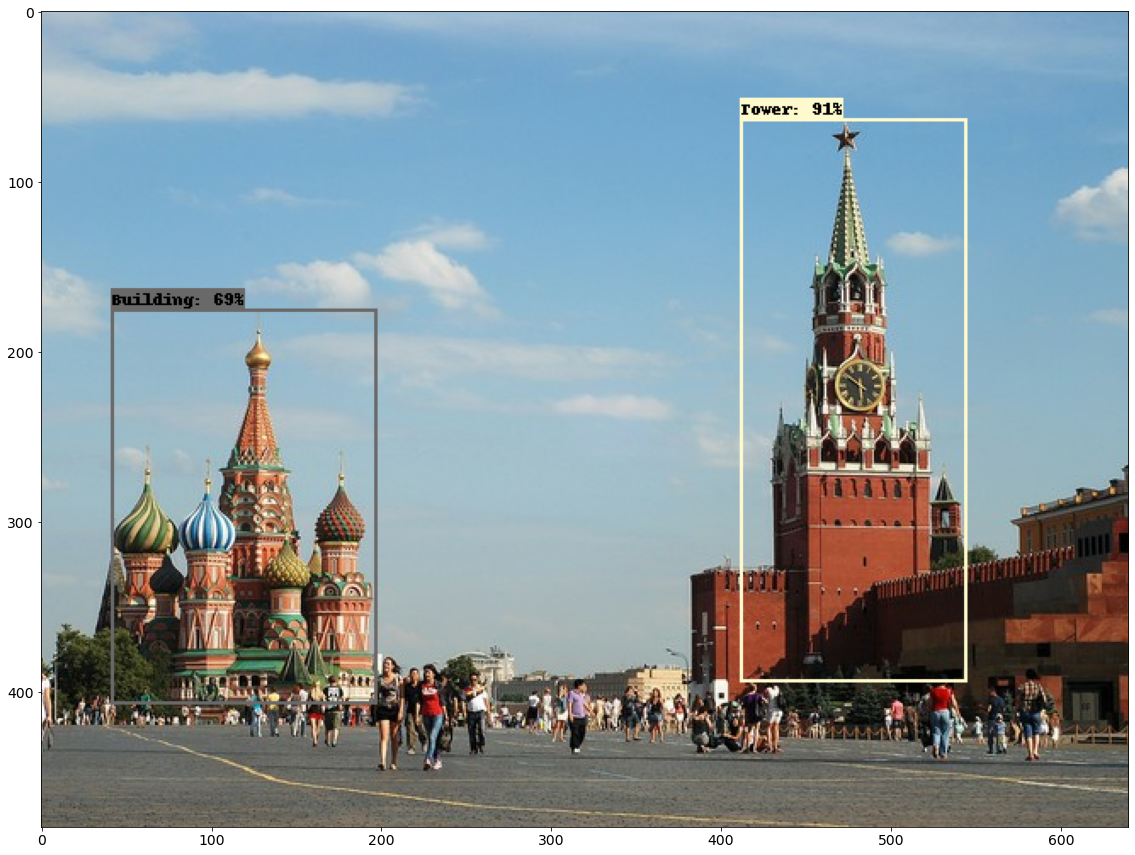

In [19]:
detect_img(image_urls[0])

Image downloaded to C:\Users\Djo\AppData\Local\Temp\tmpcdrckr9m.jpg.
Found 100 objects.
Inference time:  1.5340039730072021
Font not found, using default font.
Inference time: 1.9866437911987305


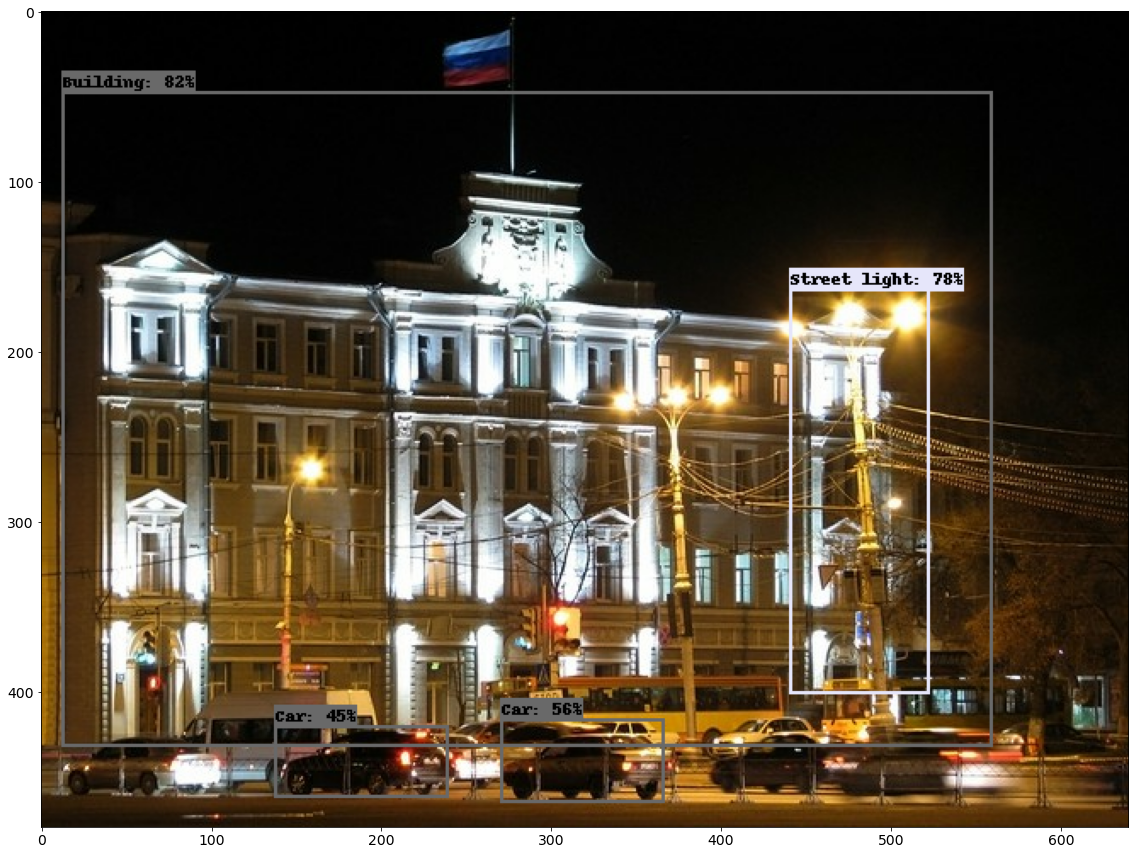

In [20]:
detect_img(image_urls[1])

Image downloaded to C:\Users\Djo\AppData\Local\Temp\tmp4u_f54f0.jpg.
Found 100 objects.
Inference time:  1.4254484176635742
Font not found, using default font.
Inference time: 1.8200263977050781


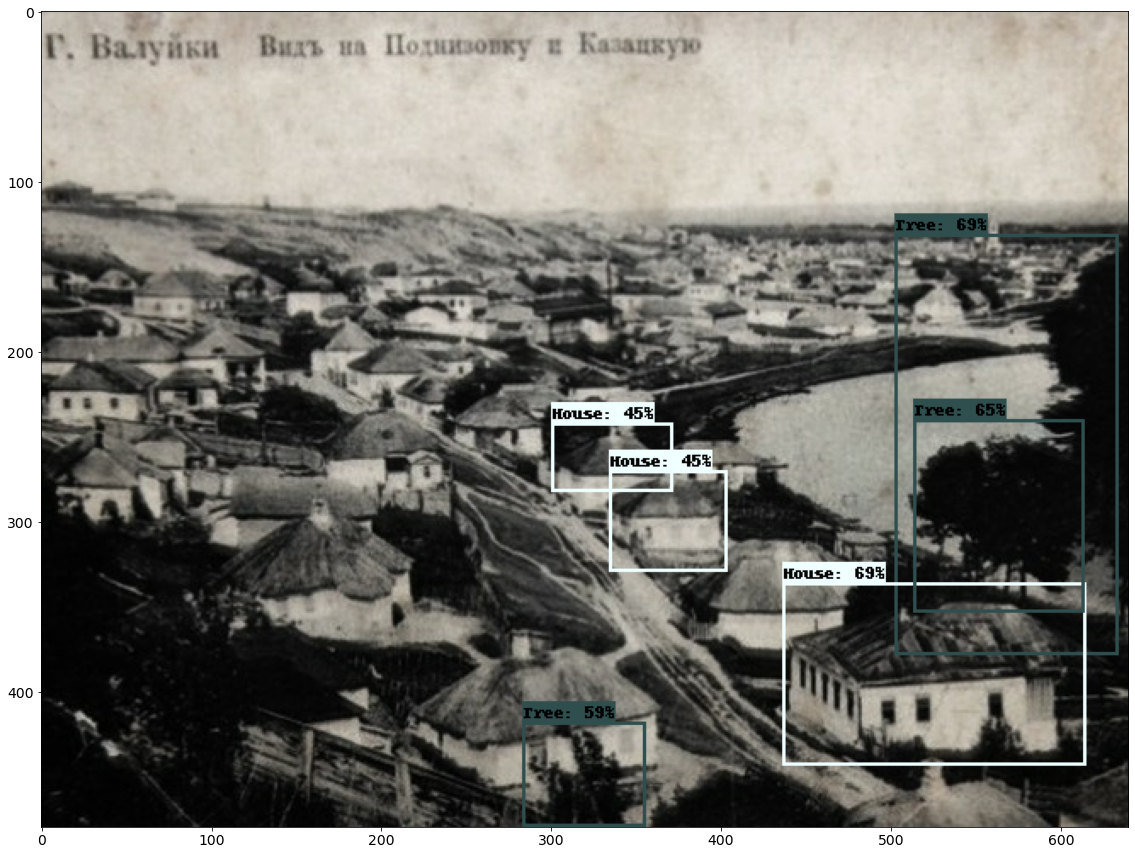

In [21]:
detect_img(image_urls[2])

Image downloaded to C:\Users\Djo\AppData\Local\Temp\tmpg82a6weh.jpg.
Found 100 objects.
Inference time:  1.5856618881225586
Font not found, using default font.
Inference time: 2.2567930221557617


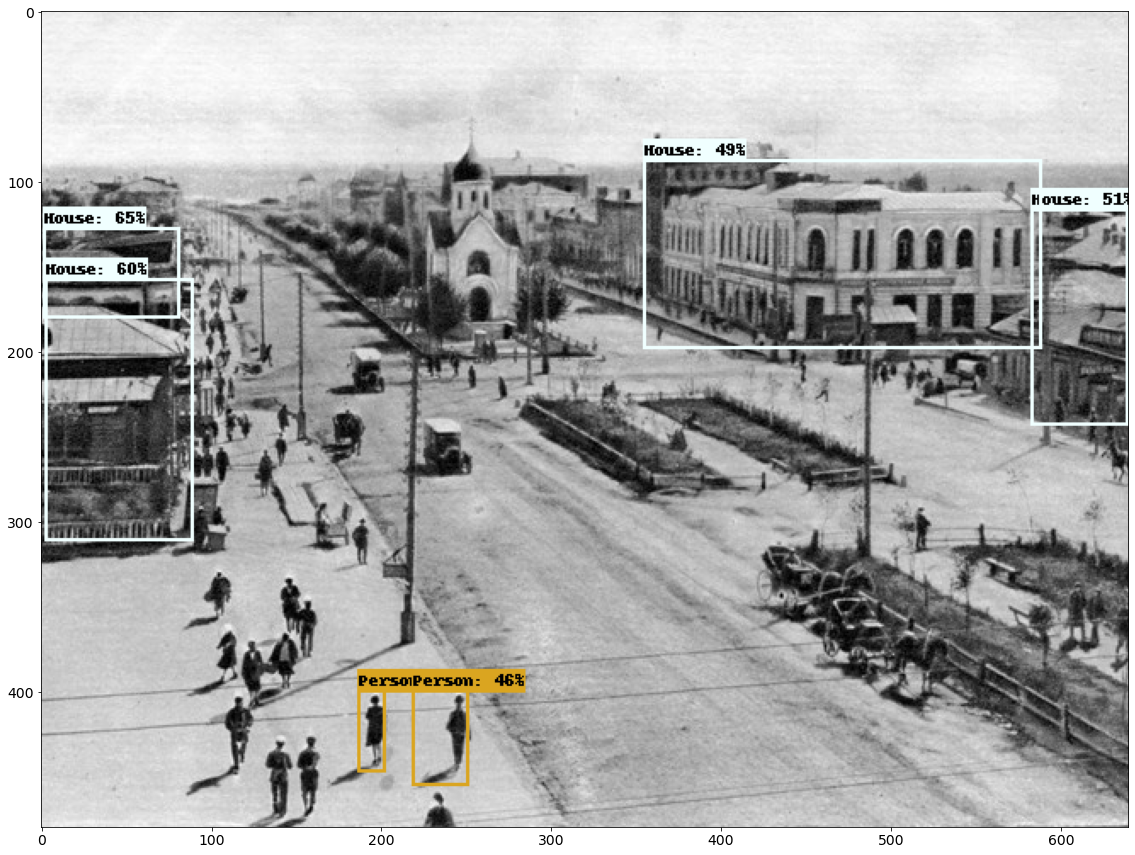

In [22]:
detect_img(image_urls[3])